To begin upload this notebook to your own drive:

### Submission Instructions:
1. **Restart the kernel** (in the menubar, select Runtime$\rightarrow$Restart runtime)
2. **Run all cells** (in the menubar, select Runtime$\rightarrow$Run All).
3. **Download the notebook** (in the menubar, select File$\rightarrow$Download .ipynb)
4. **Upload the downloaded notebook (.ipynb file) to your repository**.

Note: To use a GPU, do the following: Runtime$\rightarrow$Change runtime type$\rightarrow$ GPU

Make sure you fill in any place that says `YOUR CODE HERE`, and that no tests fail.  

# ![shakespeare](https://i.imgur.com/81YZuel.jpg)

# Generating Shakespeare Using a Character-level Language Model

### From Words to Characters
In the previous section we dealt with word-level language models. But looking again at section 1, there is nothing that constraints us to using _words_ as the basic elemnents in our model. The model we analyzed in section 1 could just as well be character-based - just replace "word" with "character", and you are good to go. In this notebook we will train a small character-based language model that will help us generate Shakespearean-like (emphasis on the _like_...) texts.

### Question 2.a
Can you think of an advantage a character-based language model could have over a word-based language model? And what about the other way around: can you think of an advantage a word-based language model could have over a character-based language model? (Add your answer to the final submission pdf).

### Using PyTorch

We'll build our language model using PyTorch. PyTorch is a [very popular](https://thegradient.pub/state-of-ml-frameworks-2019-pytorch-dominates-research-tensorflow-dominates-industry/) open-source machine learning (and deep learning) framework developed by Facebook. In short:

> Pytorch is a Python-based scientific computing package targeted at two sets of audiences:
* A replacement for NumPy to use the power of GPUs
* A deep learning research platform that provides maximum flexibility and speed

To get familiar with PyTorch, check out this [quick tutorial](https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html). In addition, another imporant difference from numpy is that PyTorch can automatically calculate the gradients needed for backpropagation, as explained [here](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html).

### Preparing the Data

Our dataset is a plain text file. For simplicity, we turn any potential unicode characters into plain ASCII by using the `unidecode` package.

In [14]:
!pip install unidecode

In [15]:
import string
import random
import re
import requests
import unidecode
url = "https://github.com/tau-nlp-course/NLP_HW2/raw/main/data/shakespeare.txt"


all_characters = string.printable
n_characters = len(all_characters)  # our vocabulary size (|V| from the handout)

dataset_as_string = unidecode.unidecode(requests.get(url).content.decode())
n_chars_in_dataset = len(dataset_as_string)
print(f'Total number of characters in our dataset: {n_chars_in_dataset}')

Total number of characters in our dataset: 1115394


To make inputs out of this big string of text, we will split it into chunks.

In [16]:
chunk_len = 400

def random_chunk():
    start_index = random.randint(0, n_chars_in_dataset - chunk_len)
    end_index = start_index + chunk_len + 1
    return dataset_as_string[start_index:end_index]

print(random_chunk())

rse is fallen upon my head;
'When he,' quoth she, 'shall split thy heart with sorrow,
Remember Margaret was a prophetess.'
Come, sirs, convey me to the block of shame;
Wrong hath but wrong, and blame the due of blame.

RICHMOND:
Fellows in arms, and my most loving friends,
Bruised underneath the yoke of tyranny,
Thus far into the bowels of the land
Have we march'd on without impediment;
And here re


### Building Our Model

Our model consists of three main components:

1. [**Embedding**](https://pytorch.org/docs/stable/nn.html#embedding). A mapping between characters and their learned representations ("word vectors") \[correspoding to ${\boldsymbol L}$ in terms of the handout\]
2. [**GRU**](https://pytorch.org/docs/stable/nn.html#gru). \[correspoding to the computation of ${\boldsymbol h}^{(t)}$ in terms of the handout\]
3. **Output Layer**. A feed-forward neural network that transforms a hidden state at a timestep into a probability distribution of the next character. \[correspoding to the computation of $\hat{\boldsymbol y}^{(t)}$ in terms of the handout\]

### Question 2.b
Complete the implementation of the `forward` method of our model.

In [17]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class OurModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(OurModel, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(input_size, hidden_size)  # In the terms of the handout, here d = D_h
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers)
        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, input_, hidden):
        # General instructions:
        # Pass the embedded input through the GRU and use the output layer to get the next character distribution.
        # return that distribution and the next hidden state.
        # You may need to play around with the dimensions a bit until you get it right. Dimension-induced frustration is good for you!
        # -------------------------
        # YOUR CODE HERE
        # Ensure input is a 1D tensor with one element (for embedding)
        if input_.dim() == 0:
            input_ = input_.unsqueeze(0)

        # Embed the input character: (1,) -> (1, hidden_size)
        embedded = self.embedding(input_)

        # Add sequence dimension for GRU: (1, hidden_size) -> (1, 1, hidden_size)
        # GRU expects (seq_len, batch, input_size)
        embedded = embedded.unsqueeze(0)  # (1, 1, hidden_size)

        # Pass through GRU
        # output: (1, 1, hidden_size), hidden: (num_layers, 1, hidden_size)
        output, hidden = self.gru(embedded, hidden)

        # Remove sequence dimension: (1, 1, hidden_size) -> (1, hidden_size)
        output = output.squeeze(0)  # or output[0]

        # Apply output layer: (1, hidden_size) -> (1, output_size)
        output = self.output_layer(output)
        # -------------------------
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.num_layers, 1, self.hidden_size))

### Creating the Training Examples

Each chunk will be turned into a tensor by looping through the characters of the string and looking up the index of each character in `all_characters`.

In [18]:
# Turn a string into list of longs
def chars_to_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return Variable(tensor)

print(chars_to_tensor('abcDEF'))

tensor([10, 11, 12, 39, 40, 41])


Now we can assemble a pair of input and target tensors (i.e. a single training example) for training, from a random chunk. The input will be all characters *except the last*, and the target will be all characters *except the first*. So if our chunk is "abc" the input will correspond to "ab" while the target is "bc".

In [19]:
def random_training_set():
    chunk = random_chunk()
    inp = chars_to_tensor(chunk[:-1])
    target = chars_to_tensor(chunk[1:])
    return inp, target

### Evaluating

To evaluate the network we will feed one character at a time, use the outputs of the network as a probability distribution for the next character, and repeat. To start generation we pass a priming string to start building up the hidden state, from which we then generate one character at a time.

In [20]:
import torch.nn.functional as F

def evaluate(prime_str='A', predict_len=100, temperature=0.8):
    hidden = model.init_hidden()
    prime_input = chars_to_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = model(prime_input[p], hidden)
    inp = prime_input[-1]

    for p in range(predict_len):
        output, hidden = model(inp, hidden)

        # Sample from the network as a multinomial distribution
        output_dist =  F.softmax(output / temperature, dim=-1)
        top_i = torch.multinomial(output_dist, 1)[0]

        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = chars_to_tensor(predicted_char)

    return predicted

### Training

The main training function

In [21]:
def train(inp, target):
    hidden = model.init_hidden()
    model.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = model(inp[c], hidden)
        loss += criterion(output, target[c].view(-1))

    loss.backward()
    optimizer.step()

    return loss.item() / chunk_len

A helper to print the amount of time passed:

In [22]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return f'{m}m {math.floor(s)}s'

In [23]:
# DO NOT DELETE THIS CELL


Define the training parameters, instantiate the model, and start training:

In [24]:
n_epochs = 2000
print_every = 100
plot_every = 10
hidden_size = 100  # (D_h from the handout)
num_layers = 1
lr = 0.005

model = OurModel(n_characters, hidden_size, n_characters, num_layers)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    loss = train(*random_training_set())
    loss_avg += loss

    if epoch % print_every == 0:
        print(f'[time elapsed: {time_since(start)}  ;  epochs: {epoch} ({epoch / n_epochs * 100}%)  ;  loss: {loss:.4}]')
        print(evaluate('Wh', 200), '\n')  # generate text starting with 'Wh'

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

[time elapsed: 0m 36s  ;  epochs: 100 (5.0%)  ;  loss: 2.111]
Whow, nous whe so thave the be'n are erest ant yor muol
Sheth oned teateat thour havee!

ELUSOLAad Aise'te ond fat here ust, whar the to 
I of the he thein beagh souch at to withotrthe on her hearve my  

[time elapsed: 1m 9s  ;  epochs: 200 (10.0%)  ;  loss: 2.128]
Whal to ther,
here at her of lidilond
To bus if leale arle frowes to and the les.

PAUS:
Me fard freave dese beat nower dor oult sop tese dester hall and thould as and my shere,
Thand;
Whe heeple bees o 

[time elapsed: 1m 44s  ;  epochs: 300 (15.0%)  ;  loss: 1.929]
Whatith of thy do as all to mage
Whow hour a wo,
Of as
And at me thould, he peer-tees,
I's sake of the wall,
For not asty as metbite agent thear there tuching weetit,
Po an, that your maet to your matie 

[time elapsed: 2m 23s  ;  epochs: 400 (20.0%)  ;  loss: 1.953]
Wheing shry shave anly gousselfe chave bood outh that with her lioth:
Coffou lodd CPongsing the prost the and my shave chame may,
Whou,

### Training Loss

Plotting the the losses that were computed during training can provide a further indication that the network was indeed learning (Add your plot to the final submission pdf).

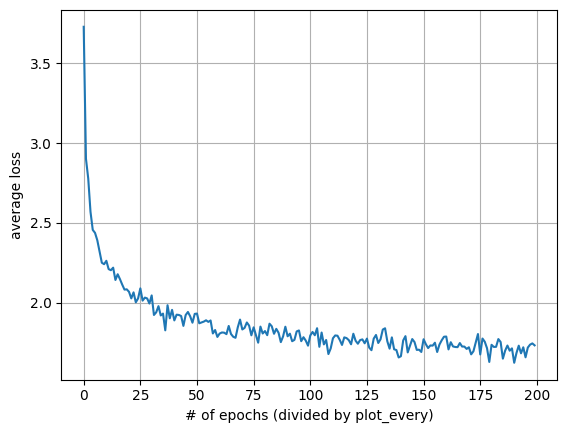

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.grid(True)
plt.xlabel('# of epochs (divided by plot_every)')
plt.ylabel('average loss')
plt.plot(all_losses)

### Q3b: Computing Perplexity on Wikipedia and Shakespeare Texts

In this section, we compute the perplexity of our character-level RNN model on two different passages: Wikipedia text and Shakespearean text.

In [26]:
import numpy as np

def compute_perplexity(model, text_string):
    """
    Compute perplexity of the character-level RNN model on a given text string.

    Args:
        model: The trained character-level RNN model
        text_string: The text string to compute perplexity on

    Returns:
        perplexity: The perplexity score
    """
    model.eval()  # Set model to evaluation mode
    hidden = model.init_hidden()

    # Convert text to tensor
    text_tensor = chars_to_tensor(text_string)
    n_chars = len(text_tensor)

    # If text is empty or has only one character, return a default value
    if n_chars <= 1:
        return float('inf')

    total_log_prob = 0.0

    # Process each character pair (input_char, target_char)
    # We need n_chars - 1 predictions (for each character except the first)
    with torch.no_grad():
        for i in range(n_chars - 1):
            input_char = text_tensor[i]
            target_char_idx = text_tensor[i + 1].item()

            # Forward pass
            output, hidden = model(input_char, hidden)

            # Apply softmax to get probability distribution
            output_dist = F.softmax(output, dim=-1)

            # Get probability of the correct (target) character
            target_prob = output_dist[0, target_char_idx].item()

            # Accumulate log probability (add small epsilon to avoid log(0))
            total_log_prob += np.log(target_prob + 1e-10)

    # Calculate perplexity: exp(-1/N * sum(log(p(correct_char))))
    # where N is the number of characters we predicted
    n_predictions = n_chars - 1
    perplexity = np.exp(-total_log_prob / n_predictions)

    return perplexity

In [28]:
%pip install -q unidecode
import unidecode

# Load the text files for perplexity computation
# Read Wikipedia text
with open('wikipedia_for_perplexity.txt', 'r', encoding='utf-8') as f:
    wikipedia_text = unidecode.unidecode(f.read())

# Read Shakespeare text
with open('shakespeare_for_perplexity.txt', 'r', encoding='utf-8') as f:
    shakespeare_text = unidecode.unidecode(f.read())

print(f'Wikipedia text length: {len(wikipedia_text)} characters')
print(f'Shakespeare text length: {len(shakespeare_text)} characters')

Wikipedia text length: 6615 characters
Shakespeare text length: 1753 characters


In [29]:
# Compute perplexity on Wikipedia text
wiki_perplexity = compute_perplexity(model, wikipedia_text)
print(f'Perplexity on Wikipedia text: {wiki_perplexity:.4f}')

Perplexity on Wikipedia text: 15.5075


In [30]:
shakespeare_perplexity = compute_perplexity(model, shakespeare_text)
print(f'Perplexity on Shakespearean text: {shakespeare_perplexity:.4f}')

Perplexity on Shakespearean text: 6.8232


In [32]:
# Display results table for Q3b
print("\n" + "="*80)
print("Q3b: Perplexity Results Table")
print("="*80)
print(f"{'Model-Data':<50} {'Wikipedia Text':<25} {'Shakespearean Text':<25}")
print("-" * 80)
print(f"{'Character-level RNN (Section 2)':<50} {wiki_perplexity:<25.4f} {shakespeare_perplexity:<25.4f}")
print("-" * 80)


Q3b: Perplexity Results Table
Model-Data                                         Wikipedia Text            Shakespearean Text       
--------------------------------------------------------------------------------
Character-level RNN (Section 2)                    15.5075                   6.8232                   
--------------------------------------------------------------------------------
